In [48]:
from typing import Dict, Tuple, List, Any
from pathlib import Path
import numpy as np
from kedro.framework.session import KedroSession
from kedro.framework.startup import bootstrap_project

In [20]:
metadata = bootstrap_project(Path.cwd().parent.parent)
with KedroSession.create(metadata.package_name,
        project_path=metadata.project_path,
        env="base",
    ) as session: 
    context = session.load_context()

2022-01-01 07:01:38,488 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-01-01 07:01:38,545 - kedro.framework.session.store - INFO - `save()` not implemented for `BaseSessionStore`. Skipping the step.


/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(


In [3]:
import pandas as pd
import ccxt

def _data_to_df(data):
    """CCXTから取得したデータをDataFrameに変換"""

    df = pd.DataFrame(
        data, columns=["Date Time", "Open", "High", "Low", "Close", "Volume"]
    )
    df["Date Time"] = pd.to_datetime(df["Date Time"] / 1000, unit="s")
    df.set_index("Date Time", inplace=True)
    return df


def get_data(ticker, timeframe="5m"):
    # 取引所のリミットレート(アクセス制限)を超えないように設定
    exchange = ccxt.ftx({"enableRateLimit": True})
    df = _data_to_df(
        exchange.fetch_ohlcv(
            ticker, 
            timeframe=timeframe, 
            params={"reverse": False})
    )
    return df

In [7]:
series = get_data(context.params["data_params"]["ticker"])

/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(


In [8]:
context.catalog.save("series", series)

2021-12-31 11:44:14,207 - kedro.io.data_catalog - INFO - Saving data to `series` (PickleDataSet)...


/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [9]:
series.head()

,Open,High,Low,Close,Volume
Date Time,,,,,
2021-12-26 06:40:00,49944.0,49944.0,49828.0,49857.0,6.472639e+06
2021-12-26 06:45:00,49857.0,49926.0,49852.0,49879.0,3.624762e+06
2021-12-26 06:50:00,49879.0,49906.0,49870.0,49899.0,2.146552e+06
2021-12-26 06:55:00,49899.0,49929.0,49879.0,49929.0,2.214015e+06
2021-12-26 07:00:00,49929.0,49935.0,49889.0,49911.0,3.076039e+06


In [11]:
import talib

def calc_features(df: pd.DataFrame):
    open = df["Open"]
    high = df["High"]
    low = df["Low"]
    close = df["Close"]
    volume = df["Volume"]
    
    hilo = (df["High"] + df["Low"]) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

In [12]:
features = calc_features(context.catalog.load("series"))

2021-12-31 11:45:08,633 - kedro.io.data_catalog - INFO - Loading data from `series` (PickleDataSet)...


/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [14]:
context.catalog.save("features", features)

2021-12-31 11:46:49,067 - kedro.io.data_catalog - INFO - Saving data to `features` (PickleDataSet)...


/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [13]:
features.head()

,Open,High,Low,Close,Volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
Date Time,,,,,,,,,,,,,,,,,,,,,
2021-12-26 06:40:00,49944.0,49944.0,49828.0,49857.0,6.472639e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-26 06:45:00,49857.0,49926.0,49852.0,49879.0,3.624762e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-26 06:50:00,49879.0,49906.0,49870.0,49899.0,2.146552e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-26 06:55:00,49899.0,49929.0,49879.0,49929.0,2.214015e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-26 07:00:00,49929.0,49935.0,49889.0,49911.0,3.076039e+06,33.023994,-17.0,-67.023994,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,25.011997


In [6]:
import pandas as pd
import numba

@numba.njit
def _calc_force_entry_price(entry_price: pd.Series, lo: pd.Series, pips: int) -> Tuple[pd.Series, pd.Series]:
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

In [7]:
def _calculate_bs_price(features: pd.DataFrame, pips: int) -> pd.DataFrame:
    # ATRで指値距離を計算します
    limit_price_dist = features["ATR"] * 0.5
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    features["buy_price"] = features["Close"] - limit_price_dist
    features["sell_price"] = features["Close"] + limit_price_dist
    return features

In [8]:
def _calculate_bs_fep(features: pd.DataFrame, pips: int) -> pd.DataFrame:
    # fep means Force Entry Price.
    features["buy_fep"], features["buy_fet"] = _calc_force_entry_price(
        entry_price=features["buy_price"].values,
        lo=features["Low"].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    features["sell_fep"], features["sell_fet"] = _calc_force_entry_price(
        entry_price=-features["sell_price"].values,
        lo=-features["High"].values, # 売りのときは高値
        pips=pips,
    )
    features["sell_fep"] *= -1
    return features

In [9]:
def calculate_estimate_target_value(features: pd.DataFrame, horizon: int, pips: int, fee: float) -> pd.DataFrame:
    # If executed a price return 1. The other return 0.
    features["buy_executed"] = ((features["buy_price"] / pips).round() > (features["Low"].shift(-1) / pips).round()).astype('float64')
    features["sell_executed"] = ((features["sell_price"] / pips).round() < (features["High"].shift(-1) / pips).round()).astype('float64')

    features["y_buy"] = np.where(
        features["buy_executed"],
        features["sell_fep"].shift(-horizon) / features["buy_price"] - 1 - 2 * fee,
        0
    )
    features["y_sell"] = np.where(
        features["sell_executed"],
        -(features["buy_fep"].shift(-horizon) / features["sell_price"] - 1) - 2 * fee,
        0
    )
    return features

In [10]:
def calculate_execution_cost(features: pd.DataFrame, fee: float) -> pd.DataFrame:
    features["buy_cost"] = np.where(
        features["buy_executed"],
        features["buy_price"] / features["Close"] - 1 + fee,
        0
    )
    features["sell_cost"] = np.where(
        features["sell_executed"],
        -(features["sell_price"] / features["Close"] - 1) + fee,
        0
    )
    return features

In [11]:
pips = context.params["data_params"]["pips"]
features = _calculate_bs_price(context.catalog.load("features"), pips)
features = _calculate_bs_fep(features, pips)
features = calculate_estimate_target_value(
    features,
    context.params["data_params"]["horizon"],
    context.params["data_params"]["pips"],
    context.params["data_params"]["fee"],
)
features = calculate_execution_cost(
    features, 
    context.params["data_params"]["fee"]
)

2022-01-01 06:29:06,385 - kedro.io.data_catalog - INFO - Loading data from `features` (PickleDataSet)...


/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")
/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(


In [55]:
import matplotlib.pylab as plt
plt.style.use("ggplot")

def plot_prob(df: pd.DataFrame):
    df['buy_executed'].rolling(1000).mean().plot(label='buy')
    df['sell_executed'].rolling(1000).mean().plot(label='sale')
    plt.title("execution prob")
    plt.legend()
    plt.savefig(
        "../../../.."+"/".join(context.catalog.datasets.execution_prob._filepath.parts)
        ,bbox_inches="tight")
    plt.show()

def plot_fet(df: pd.DataFrame):
    print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
    df['buy_fet'].rolling(1000).mean().plot(label='buy')
    df['sell_fet'].rolling(1000).mean().plot(label='sale')
    plt.title('Average time to exit')
    plt.legend()
    plt.savefig(
        "../../../.."+"/".join(context.catalog.datasets.average_time_to_exit._filepath.parts)
        ,bbox_inches="tight")
    plt.show()

    df['buy_fet'].hist(alpha=0.3, label='buy')
    df['sell_fet'].hist(alpha=0.3, label='sale')
    plt.title('Time distribution to exit')
    plt.legend()
    plt.savefig(
        "../../../.."+"/".join(context.catalog.datasets.time_distribution_to_exit._filepath.parts)
        ,bbox_inches="tight")
    plt.show()

def plot_return(df: pd.DataFrame):
    print('毎時刻、この執行方法でトレードした場合の累積リターン')
    df['y_buy'].cumsum().plot(label='buy')
    df['y_sell'].cumsum().plot(label='sale')
    plt.title('cumsum reaturn')
    plt.legend()
    plt.savefig(
        "../../../.."+"/".join(context.catalog.datasets.cumsum_reaturn._filepath.parts)
        ,bbox_inches="tight")
    plt.show()

/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


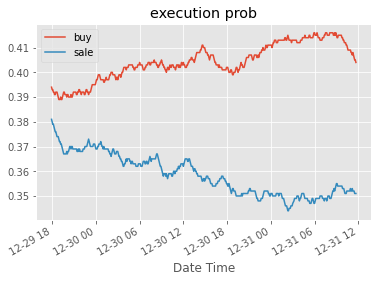

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


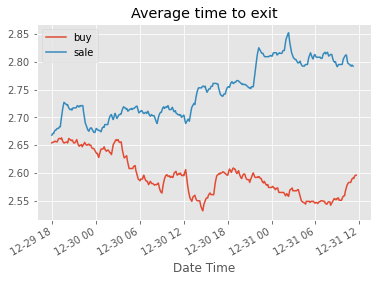

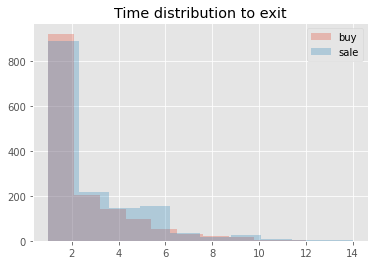

毎時刻、この執行方法でトレードした場合の累積リターン


/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


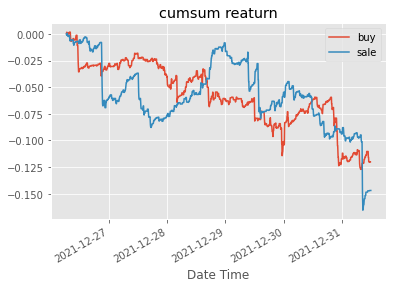

In [56]:
plot_prob(features)
plot_fet(features)
plot_return(features)

In [18]:
from typing import Dict, List
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit  # cross_val_score, KFold

def _cross_val_predict(estimator, X, y, cv):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

def train(features: pd.DataFrame, feature_columns: List[str], model_params: Dict[str,Any]):
    features = features.dropna()
    regressor = lgb.LGBMRegressor(**model_params["hyper_parameters"])
    cv_indicies = list(TimeSeriesSplit().split(features))
    features["y_hat_buy"] = _cross_val_predict(regressor, features[feature_columns].values, features["y_buy"].values, cv=cv_indicies)
    features["y_hat_sell"] = _cross_val_predict(regressor, features[feature_columns].values, features["y_sell"].values, cv=cv_indicies)
    return features


In [46]:
context.catalog.save("model_input", features)

2022-01-01 08:10:52,788 - kedro.io.data_catalog - INFO - Saving data to `model_input` (PickleDataSet)...


/usr/local/lib/python3.8/site-packages/kedro/config/config.py:296: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /backtest-example/backtest-example/conf/base
  warn(
/usr/local/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/backtest-example/backtest-example/conf/base'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")
